# 2. CAM, Grad-CAM용 모델 준비하기

In [2]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 87.7 MB/s eta 0:00:00:00:0100:01


In [1]:
import os
import shutil
import scipy.io as sio
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch.nn.functional as F

import xml.etree.ElementTree as ET
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

사용할 데이터 설명?
[stanford_dogs in Tensorflow Datasets](https://www.tensorflow.org/datasets/catalog/stanford_dogs)

- Images 폴더
    - 각 폴더 내에는 class 별 폴더로 구성되어있고 내부에는 이미지가 저장되어있습니다.
- Annotation 폴더
    - Images와 마찬가지로 class 별 폴더로 구성되어있고 내부에는 각 이미지에 대한 메타데이터가 저장되어있습니다.
- list.mat 파일
    - 각 파일 내에는 train/test 셋의 파일명이 정리되어있습니다.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## 2-1 데이터셋 준비하기

In [3]:
save_dir = 'data'
    
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Directory '{save_dir}' created.")

In [6]:
# img_tar = os.path.join(save_dir, 'images.tar')
# ann_tar = os.path.join(save_dir, 'annotation.tar')
# list_tar = os.path.join(save_dir, 'lists.tar')

# !wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar -O {img_tar}
# !wget http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar -O {ann_tar}
# !wget http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar -O {list_tar}

# !tar -xf {img_tar} -C {save_dir}
# !tar -xf {ann_tar} -C {save_dir}
# !tar -xf {list_tar} -C {save_dir}

# !rm {img_tar}
# !rm {ann_tar}
# !rm {list_tar}

In [4]:
# 원본 데이터 경로 (압축 해제 후 폴더)
images_dir = os.path.join('data/Images')   # 이미지들이 위치한 폴더
mat_dir = os.path.join('data')   # 프로젝트 루트 디렉토리

# .mat 파일 경로 (train_list.mat와 test_list.mat가 각각 같은 구조라고 가정)
train_mat_path = os.path.join(mat_dir, 'train_list.mat')
test_mat_path = os.path.join(mat_dir, 'test_list.mat')

# .mat 파일 로드
train_mat = sio.loadmat(train_mat_path)
test_mat = sio.loadmat(test_mat_path)

# train_mat와 test_mat 내부에 'file_list'와 'labels' 등이 있음
train_file_list = train_mat['file_list']
train_labels = train_mat['labels'].squeeze()  # (N,)
test_file_list = test_mat['file_list']
test_labels = test_mat['labels'].squeeze()

# 최종적으로 ImageFolder 구조로 재구성할 대상 폴더 생성 (예: stanford_dogs/train, stanford_dogs/test)
base_dir = 'stanford_dogs'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

def process_mat_file(file_list_array, split_dir):
    """
    .mat 파일에서 로드한 file_list_array를 사용해,
    split_dir(예: train 혹은 test)에 클래스별 폴더를 생성하고 이미지를 복사합니다.
    """
    num_files = file_list_array.shape[0]
    for idx in range(num_files):
        # file_list_array[idx]는 보통 array([<파일경로>]) 형태입니다.
        # 따라서, array([<파일경로>]).item()을 사용하면 실제 문자열을 얻을 수 있습니다.
        file_path = file_list_array[idx][0].item()

        # 혹시 bytes 타입이면 문자열로 디코딩
        if isinstance(file_path, bytes):
            file_path = file_path.decode('utf-8')

        # 파일 경로 예시: 'n02116738-African_hunting_dog/n02116738_2988.jpg'
        # 클래스 이름은 파일 경로의 최상위 폴더명 (예: 'n02116738-African_hunting_dog')
        class_folder = file_path.split('/')[0]

        # 대상 클래스 폴더 생성
        dest_folder = os.path.join(split_dir, class_folder)
        os.makedirs(dest_folder, exist_ok=True)

        # 원본 이미지 경로: Images 폴더 아래에 file_path 위치
        src_path = os.path.join(images_dir, file_path)
        # 대상 이미지 경로: dest_folder 아래에 원본 파일명 그대로 복사
        dest_path = os.path.join(dest_folder, os.path.basename(file_path))

        # 파일 존재 여부 확인 후 복사
        if os.path.exists(src_path):
            shutil.copy(src_path, dest_path)
        else:
            print(f"File not found: {src_path}")

print("Processing train set...")
process_mat_file(train_file_list, train_dir)
print("Processing test set...")
process_mat_file(test_file_list, test_dir)

print("Dataset reorganization complete.")

Processing train set...
Processing test set...
Dataset reorganization complete.


In [5]:
class StanfordDogsDatasetWithBBox(datasets.ImageFolder):
    def __init__(self, root, annotation_root, transform=None):
        super().__init__(root, transform=transform)
        self.annotation_root = annotation_root  # 예: '/content/Annotation'
        self.new_size = (224, 224)

    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        path, _ = self.samples[index]

        rel_path = os.path.relpath(path, self.root)
        annot_filename = os.path.splitext(os.path.basename(rel_path))[0]
        annot_folder = os.path.dirname(rel_path)
        annot_path = os.path.join(self.annotation_root, annot_folder, annot_filename)

        # bbox 기본값 (예: [ymin, xmin, ymax, xmax])
        bbox = [0.0, 0.0, 0.0, 0.0]

        if os.path.exists(annot_path):
            try:
                # 확장자가 없지만 XML 형식의 파일이라고 가정하고 파싱
                tree = ET.parse(annot_path)
                root_xml = tree.getroot()
                # 첫 번째 object 태그에서 bndbox 정보를 읽음
                obj = root_xml.find('object')
                if obj is not None:
                    bndbox = obj.find('bndbox')
                    if bndbox is not None:
                        xmin = float(bndbox.find('xmin').text)
                        ymin = float(bndbox.find('ymin').text)
                        xmax = float(bndbox.find('xmax').text)
                        ymax = float(bndbox.find('ymax').text)
                        # XML 내 <size> 태그에서 원본 이미지 크기 획득
                        size = root_xml.find('size')
                        w = float(size.find('width').text)
                        h = float(size.find('height').text)
                        new_h, new_w = self.new_size
                        # bbox 좌표 순서: [ymin, xmin, ymax, xmax]
                        bbox = [xmin * (new_w / w), ymin * (new_h / h),
                                xmax * (new_w / w), ymax * (new_h / h)]
                    else:
                        print(f"bndbox 태그를 찾을 수 없습니다: {annot_path}")
                else:
                    print(f"object 태그를 찾을 수 없습니다: {annot_path}")
            except Exception as e:
                print(f"Error parsing {annot_path}: {e}")
        else:
            print(f"Annotation file not found: {annot_path}")

        return image, label, bbox

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 데이터셋 경로 (재구성한 ImageFolder 형식)
train_dir = os.path.join('stanford_dogs', 'train')
test_dir = os.path.join('stanford_dogs', 'test')
# Annotation 폴더 경로 (예: '/root/Annotation')
annotation_dir = os.path.join(os.getenv("HOME"), 'work/class_activation_map/Annotation')

# 커스텀 데이터셋 생성: image, label, bbox 반환
train_dataset = StanfordDogsDatasetWithBBox(root=train_dir, annotation_root=annotation_dir, transform=transform)
valid_dataset = StanfordDogsDatasetWithBBox(root=test_dir, annotation_root=annotation_dir, transform=transform)

batch_size = 12
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")
print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(valid_dataset)}")

Number of classes: 120
Train samples: 12000
Test samples: 8580


In [7]:
def visualize(sample):
    img_tensor, label, bbox = sample

    # 인덱스와 클래스 정보
    print("Label index:", label)
    print("Class name:", train_dataset.classes[label])

    # 정규화 복원 전처리 시 사용한 평균과 표준편차
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # tensor의 shape: (C, H, W) -> (H, W, C)
    img_np = img_tensor.permute(1, 2, 0).numpy()
    img_np = std * img_np + mean
    img_np = np.clip(img_np, 0, 1)

    plt.figure(figsize=(6,6))
    plt.imshow(img_np)
    plt.title(f"Class: {train_dataset.classes[label]}")
    plt.axis('off')
    plt.show()

Label index: 0
Class name: n02085620-Chihuahua


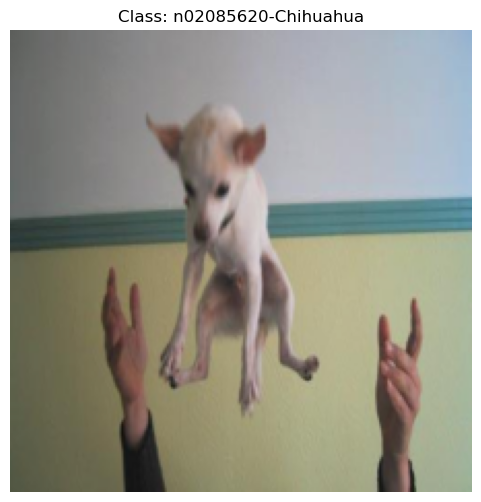

In [8]:
# 임의의 한 샘플 선택 (여기서는 첫 번째 샘플을 사용)
train_sample = train_dataset[0]

visualize(train_sample)

Label index: 0
Class name: n02085620-Chihuahua


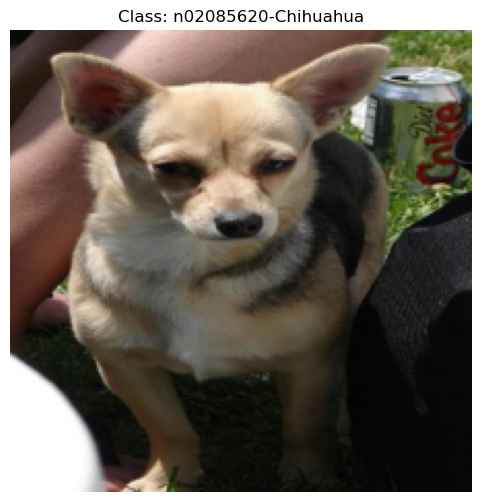

In [9]:
# 임의의 한 샘플 선택 (여기서는 첫 번째 샘플을 사용)
test_sample = valid_dataset[0]

visualize(test_sample)

## 2-2 물체의 위치정보
object에 담긴 정보는 name, pose, truncated, difficult, bndbox로 각각 다음과 같은 의미를 갖고 있습니다.

- name 객체의 클래스 이름을 나타냅니다. 여기서는 'Chihuahua'로, 해당 객체가 치와와 품종의 개임을 의미합니다.
- pose 객체의 자세(orientation)를 나타내며, 여기서는 'Unspecified'로 구체적인 자세 정보는 제공되지 않습니다.
- truncated 객체가 이미지 경계에 의해 잘려(truncated) 있는지 여부를 나타냅니다. 0은 잘리지 않았음을 의미합니다.
- difficult 객체 인식이 어려운 정도를 나타내는 플래그로, 0은 비교적 인식하기 쉬운 객체임을 의미합니다.
- bndbox 객체의 위치를 사각형 영역(바운딩 박스)으로 나타내는 정보입니다.

- \<xmin>25\</xmin>: 바운딩 박스의 왼쪽 경계 (가로 좌표)

- \<ymin>10\</ymin>: 바운딩 박스의 상단 경계 (세로 좌표)

- \<xmax>276\</xmax>: 바운딩 박스의 오른쪽 경계 (가로 좌표)

- \<ymax>498\</ymax>: 바운딩 박스의 하단 경계 (세로 좌표)

바운딩 박스를 라벨링하는 방법은 아주 다양합니다. 그 중 주로 사용되는 방법은 'xywh' 또는 'minmax'로 표기하는 방법입니다. (더 다양하긴 함)

- 'xywh' 는 바운딩박스 중심점을 x, y로 표기하고, 사각형의 너비 w와 높이 h를 표기하는 방법입니다.
    - (예) (x_center, y_center, width, height)
    - x, y가 중심점이 아니라 좌측 상단의 점을 가리킬 수도 있습니다.
- 'minmax'는 바운딩박스를 이루는 좌표의 최소값과 최대값을 통해 표기하는 방법입니다.
    - (예) (x_min, x_max, y_min, y_max)
    - 좌표의 절대값이 아니라, 전체 이미지의 너비와 높이를 기준으로 normalize한 상대적인 값을 표기하는 것이 일반적입니다.


In [10]:
# Annotation 폴더에서 데이터를 골라보세요
annotation_path = os.path.join('data/Annotation/n02085620-Chihuahua/n02085620_10074')

# XML 파일 파싱
tree = ET.parse(annotation_path)
root = tree.getroot()

for elem in root.iter():
    print(f"{elem.tag}: {elem.text}")

annotation: 
	
folder: 02085620
filename: n02085620_10074
source: 
		
database: ImageNet database
size: 
		
width: 333
height: 500
depth: 3
segment: 0
object: 
		
name: Chihuahua
pose: Unspecified
truncated: 0
difficult: 0
bndbox: 
			
xmin: 25
ymin: 10
xmax: 276
ymax: 498


## 2-3 CAM을 위한 모델 만들기

In [12]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))
model = model.to(device)

/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 184MB/s]


In [13]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## 2-4 CAM 모델 학습하기

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [17]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=2):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        print(f"\nEpoch {epoch+1}/{num_epochs} 시작")
        for batch_idx, (images, labels, _) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            if (batch_idx + 1) % 50 == 0:
                print(f"  Step {batch_idx+1} - Loss: {loss.item():.4f}")

        train_loss = running_loss / (batch_idx + 1)
        train_acc = correct / total
        print(f"Train - Loss: {train_loss:.4f}, Accuracy: {train_acc*100:.2f}%")

        # 검증 단계
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels, _ in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()
        test_loss = running_loss / len(valid_loader)
        test_acc = correct / total
        print(f"Validation - Loss: {test_loss:.4f}, Accuracy: {test_acc*100:.2f}%")

In [18]:
%%time

train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=2)


Epoch 1/2 시작
  Step 50 - Loss: 4.8071
  Step 100 - Loss: 4.1036
  Step 150 - Loss: 3.2444
  Step 200 - Loss: 4.0322
  Step 250 - Loss: 2.9058
  Step 300 - Loss: 2.8636
  Step 350 - Loss: 3.3889
  Step 400 - Loss: 2.8752
  Step 450 - Loss: 2.5696
  Step 500 - Loss: 2.3015
  Step 550 - Loss: 2.4966
  Step 600 - Loss: 2.3738
  Step 650 - Loss: 2.8243
  Step 700 - Loss: 2.4603
  Step 750 - Loss: 3.2219
  Step 800 - Loss: 2.1063
  Step 850 - Loss: 1.7350
  Step 900 - Loss: 2.6108
  Step 950 - Loss: 3.1101
  Step 1000 - Loss: 2.0361
Train - Loss: 3.1786, Accuracy: 22.49%
Validation - Loss: 2.6440, Accuracy: 31.21%

Epoch 2/2 시작
  Step 50 - Loss: 2.0464
  Step 100 - Loss: 1.4897
  Step 150 - Loss: 1.6053
  Step 200 - Loss: 2.4413
  Step 250 - Loss: 2.2143
  Step 300 - Loss: 2.0191
  Step 350 - Loss: 2.7153
  Step 400 - Loss: 1.8509
  Step 450 - Loss: 2.3929
  Step 500 - Loss: 2.1402
  Step 550 - Loss: 1.3191
  Step 600 - Loss: 2.1695
  Step 650 - Loss: 2.4705
  Step 700 - Loss: 2.1591
  Step

In [14]:
cam_model_path = os.path.join("data/cam_model.pt")

torch.save(model, cam_model_path)

# 3. CAM

## CAM(Class Activation Map) 생성 과정 정리

CAM을 생성하기 위해서는 다음의 세 가지 핵심 요소가 필요하다.

### 1. 특성 맵(Feature Map)

모델의 특정 합성곱 계층(여기서는 *layer4*)에서 추출되는 공간적 특징 정보이다.
입력 이미지의 패턴, 구조, 객체 형태 등이 이 특성 맵에 담겨 있다.

### 2. Softmax 직전 분류기(FC Layer)의 가중치

Fully-connected layer는 각 클래스가 어떤 특징 채널에 의존하는지를 학습한다.
따라서 FC 가중치는 “특정 클래스가 어떤 feature map 채널을 얼마나 중요하게 사용하는지”를 나타낸다.

### 3. 원하는 클래스의 출력값

CAM은 특정 클래스에 대한 주목 영역을 시각화하는 것이기 때문에,
예측 결과 중 가장 높은 클래스를 선택하거나, 관심 있는 특정 클래스를 직접 지정해서 사용한다.

---

## CAM 계산 과정

### 1. 특정 레이어의 출력(Feature Map) 저장

* `model.layer4`에 **forward hook**을 등록해,
* 이미지가 네트워크를 통과하는 과정에서 해당 레이어의 출력(feature map)을 리스트에 저장한다.

### 2. 모델 예측 및 클래스 선택

* 입력 이미지를 모델에 넣어 feedforward 실행.
* 배치 첫 번째 이미지의 예측 결과 중 가장 높은 점수를 가진 클래스를 선택한다.
  → CAM은 이 클래스에 대한 주목 영역을 의미하게 된다.

### 3. FC 가중치와 Feature Map의 가중합으로 CAM 계산

* 선택한 클래스에 대응하는 **FC layer의 가중치 벡터**를 가져온다.
* 저장된 feature map의 채널별로 이 가중치를 곱하고 더해준다.
  → 즉, “클래스 A는 어떤 채널을 얼마나 중요하게 보았는가”를 반영하는 선형 결합이다.
* 이렇게 생성된 2D 맵이 바로 CAM이다.

### 4. 정규화 및 시각화

* ReLU로 음수를 제거한다.
* 최소/최대 값을 이용해 0~1 구간으로 정규화한다.
* 필요하다면 `cv2.resize()` 등을 사용하여 입력 이미지 크기로 업샘플링해 시각화한다.


In [15]:
# # 임시 모델 가져옴
# best_ckpt = torch.load("model/cam_resnet50_best.pth")
# model.load_state_dict(best_ckpt["model_state_dict"])

<All keys matched successfully>

In [16]:
def unnormalize(img_tensor):
    """
    img_tensor: [C, H, W] 텐서 (전처리 상태, 예: normalization 적용됨)
    ImageNet 평균 및 표준편차를 이용하여 복원 (RGB 순서)
    """
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = img_tensor.cpu().numpy().transpose(1, 2, 0)
    img = std * img + mean
    img = np.clip(img, 0, 1)
    img = np.uint8(255 * img)
    return img

In [17]:
image, label, bbox = train_dataset[0]
sample_image = image.unsqueeze(0).to(device)

In [18]:
model = torch.load(cam_model_path, weights_only=False)

In [19]:
def generate_cam(model, image):
    model.eval()
    features = []

    def hook(module, input, output):
        features.append(output.detach())
    hook_handle = model.layer4.register_forward_hook(hook)

    output = model(image)
    hook_handle.remove()

    # 예측된 클래스 선택 (배치의 첫 번째 이미지 기준)
    pred_class = output.argmax(dim=1).item()

    # 모델의 fc layer 가중치가 모델과 동일한 디바이스에 있도록 처리
    fc_weights = model.fc.weight.data.to(image.device)

    # features[0]: shape [1, num_features, H, W]
    fmap = features[0][0]  # 첫 번째 이미지의 feature map
    cam = torch.zeros(fmap.shape[1:], dtype=torch.float32, device=image.device)

    # fc 가중치와 feature map의 각 채널을 가중합
    for i, w in enumerate(fc_weights[pred_class]):
        cam += w * fmap[i, :, :]
    cam = cam.cpu().numpy()

    # CAM 정규화
    cam = np.maximum(cam, 0)
    cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam) + 1e-8)

    return cam

In [20]:
cam = generate_cam(model, sample_image)

In [21]:
def visualize_cam(cam):
    plt.imshow(cam, cmap='jet')
    plt.colorbar()
    plt.title("CAM")
    plt.axis('off')
    plt.show()

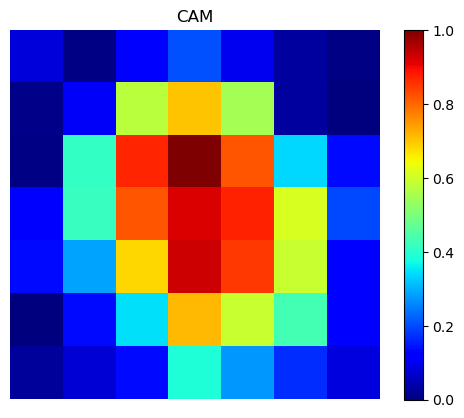

In [22]:
visualize_cam(cam)

그려진 CAM을 원본 이미지에 합쳐본다

In [23]:
def visualize_cam_on_image(cam, img, alpha=0.5):
    # CAM 크기를 원본 이미지 크기로 조정
    cam_resized = cv2.resize(cam, (img.shape[1], img.shape[0]))

    # CAM을 컬러 heatmap으로 변환 (cv2.applyColorMap는 BGR로 반환하므로 RGB로 변경)
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # 원본 이미지와 heatmap을 alpha blending
    overlay = heatmap * alpha + img * (1 - alpha)
    overlay = overlay.astype(np.uint8)

    plt.figure(figsize=(8,8))
    plt.imshow(overlay)
    plt.title("CAM Overlay on Image")
    plt.axis('off')
    plt.show()

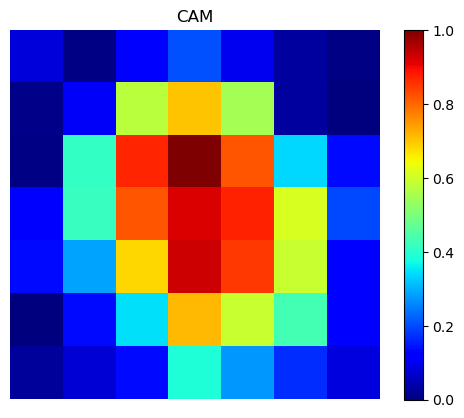

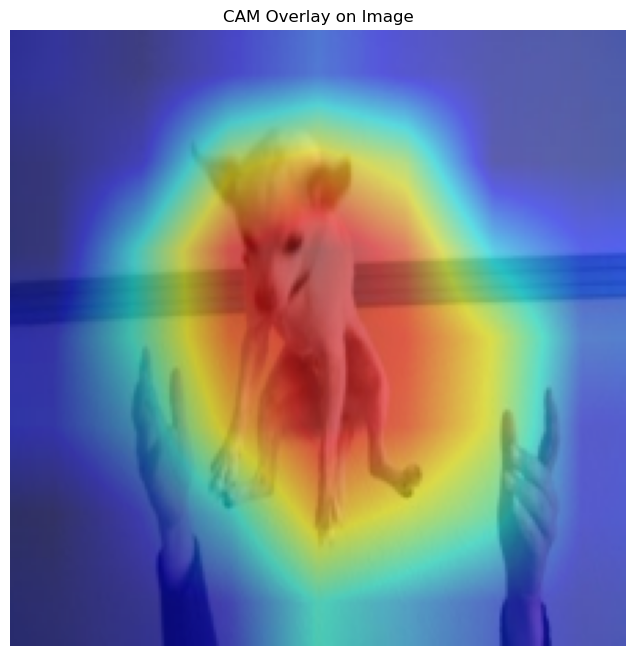

In [24]:
# 원본 이미지 복원
orig_img = unnormalize(image)

# CAM 단독 시각화
visualize_cam(cam)

# 원본 이미지 위에 CAM overlay 시각화
visualize_cam_on_image(cam, orig_img)

# 4. Grad-CAM

Grad-CAM은 **특정 레이어의 feature map**과 **관심 클래스의 예측값 그래디언트**를 이용해,
모델이 어떤 공간적 영역에 주목했는지 시각화하는 방법입니다.

---

### 핵심 흐름

1. **관찰할 레이어 선택**

   * 원하는 합성곱 레이어(`activation_layer`)를 hook으로 추출.

2. **feature map과 gradient 수집**

   * forward hook → feature map 저장
   * backward hook → 해당 레이어의 gradient 저장

3. **채널별 가중치 계산**

   * gradient에 GAP 적용 → 채널별 중요도(weight) 계산

4. **CAM 생성**

   * weight와 feature map의 가중합 → ReLU 적용 → CAM 완성
   * 필요 시 입력 이미지 크기로 업샘플링

---

### 정리

Grad-CAM은 선택한 레이어에서 **그래디언트를 통해 채널별 중요도를 구하고**,
이를 feature map에 가중합해 **모델이 클래스 판단에 주목한 영역**을 시각화하는 방법입니다.
CAM과 달리 **임의의 레이어**에서도 적용 가능하다는 장점이 있습니다.


In [25]:
def generate_grad_cam(model, image, target_layer_name):
    model.eval()
    features = {}
    gradients = {}

    # forward hook: 대상 레이어의 출력을 저장
    def forward_hook(module, input, output):
        features['value'] = output.detach()

    # backward hook: 대상 레이어의 gradient를 저장
    def backward_hook(module, grad_in, grad_out):
        gradients['value'] = grad_out[0].detach()

    # 모델 내에서 이름이 target_layer_name과 일치하는 레이어 검색
    target_layer = dict(model.named_modules()).get(target_layer_name, None)
    if target_layer is None:
        raise ValueError(f"Layer '{target_layer_name}' not found in the model.")

    # hook 등록
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)

    # 순전파 실행
    output = model(image)
    pred_class = output.argmax(dim=1).item()

    # 예측 클래스에 대해 backward 수행
    model.zero_grad()
    score = output[0, pred_class]
    score.backward()

    # hook 제거
    forward_handle.remove()
    backward_handle.remove()

    # 저장된 feature map과 gradient 추출 (shape: [C, H, W])
    fmap = features['value'][0]
    grads = gradients['value'][0]

    # 각 채널에 대해 gradient의 global average pooling 계산 (weight 역할)
    weights = torch.mean(grads, dim=(1, 2))

    # weighted sum: 각 채널의 feature map에 weight를 곱해 합산
    grad_cam = torch.zeros(fmap.shape[1:], dtype=torch.float32, device=fmap.device)
    for i, w in enumerate(weights):
        grad_cam += w * fmap[i, :, :]
    grad_cam = grad_cam.cpu().numpy()

    # ReLU 적용 및 정규화: 음수 값 제거 및 [0,1] 범위로 스케일링
    grad_cam = np.maximum(grad_cam, 0)
    grad_cam = (grad_cam - grad_cam.min()) / (grad_cam.max() - grad_cam.min() + 1e-8)

    return grad_cam

/opt/conda/lib/python3.12/site-packages/torch/nn/modules/module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


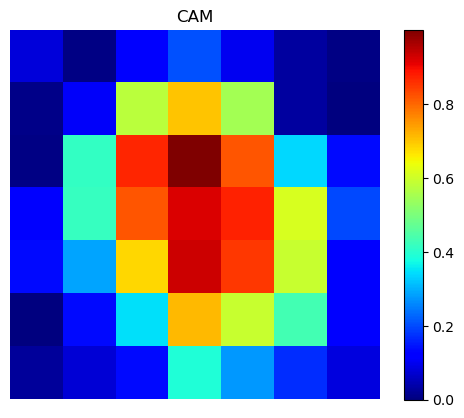

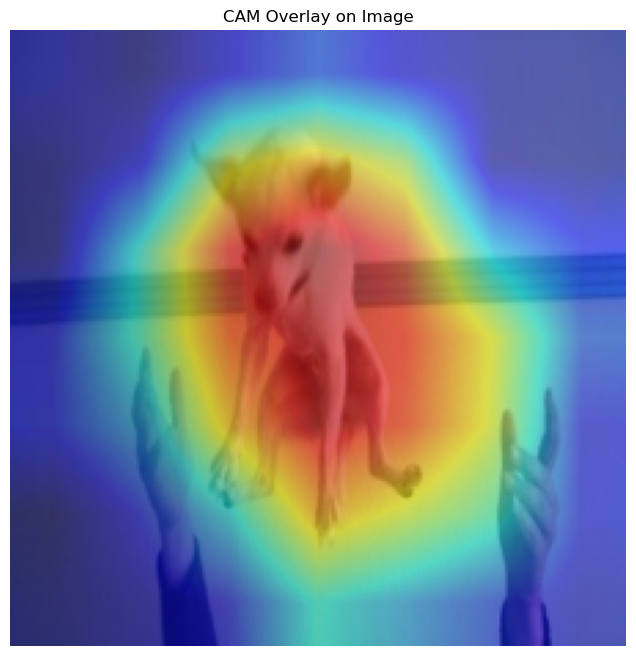

In [26]:
# layer4 사용
grad_cam = generate_grad_cam(model, sample_image, target_layer_name="layer4")

# Grad-CAM 단독 시각화
visualize_cam(grad_cam)

# 전처리된 이미지를 원본 이미지로 복원 후 overlay 시각화
orig_img = unnormalize(image)
visualize_cam_on_image(grad_cam, orig_img)

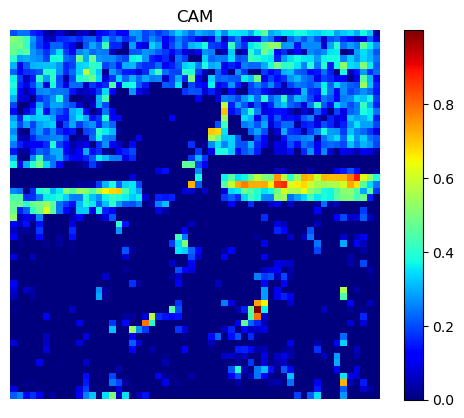

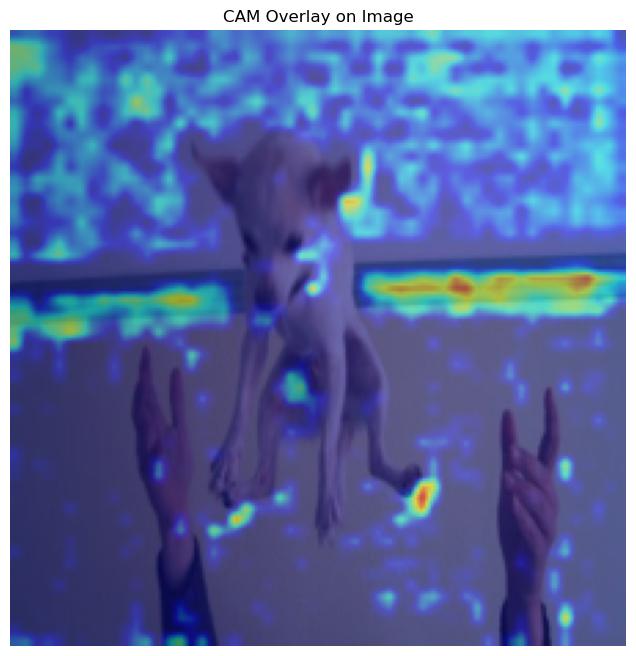

In [27]:
grad_cam = generate_grad_cam(model, sample_image, target_layer_name="layer1")

# Grad-CAM 단독 시각화
visualize_cam(grad_cam)

# 전처리된 이미지를 원본 이미지로 복원 후 overlay 시각화
orig_img = unnormalize(image)
visualize_cam_on_image(grad_cam, orig_img)

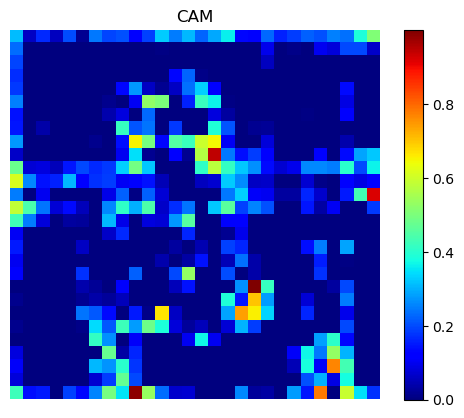

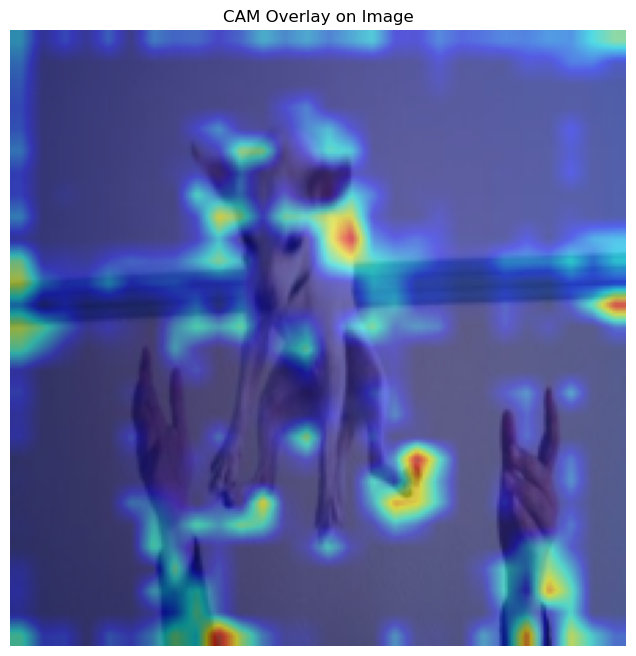

In [28]:
grad_cam = generate_grad_cam(model, sample_image, target_layer_name="layer2")

# Grad-CAM 단독 시각화
visualize_cam(grad_cam)

# 전처리된 이미지를 원본 이미지로 복원 후 overlay 시각화
orig_img = unnormalize(image)
visualize_cam_on_image(grad_cam, orig_img)

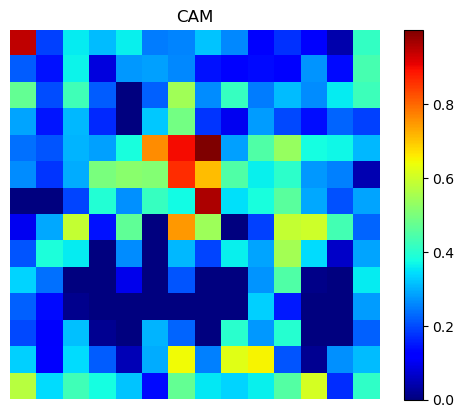

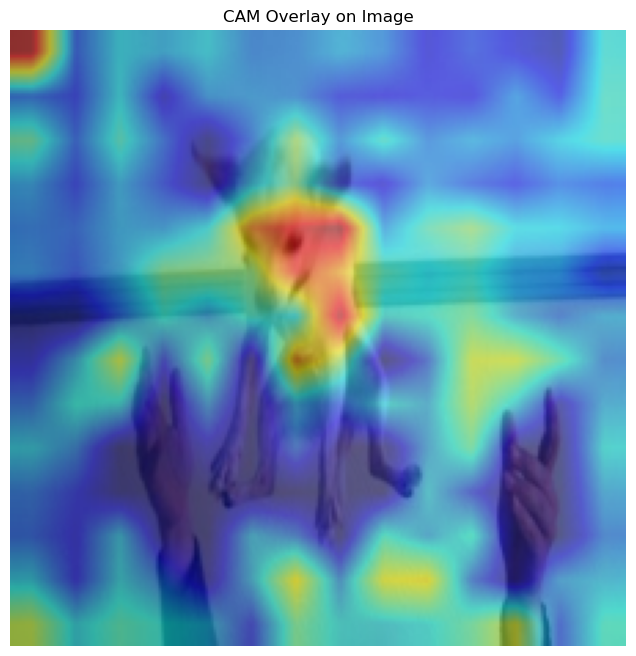

In [29]:
grad_cam = generate_grad_cam(model, sample_image, target_layer_name="layer3")

# Grad-CAM 단독 시각화
visualize_cam(grad_cam)

# 전처리된 이미지를 원본 이미지로 복원 후 overlay 시각화
orig_img = unnormalize(image)
visualize_cam_on_image(grad_cam, orig_img)

# 5. Detection with CAM
- Bounding Box를 활용할 것이다.
- 그래서 특정 지표를 사용할 것이다.

### Intersection over Union (IoU)

Bounding Box를 활용한 객체 검출 성능을 평가할 때 **IoU**가 자주 사용된다.

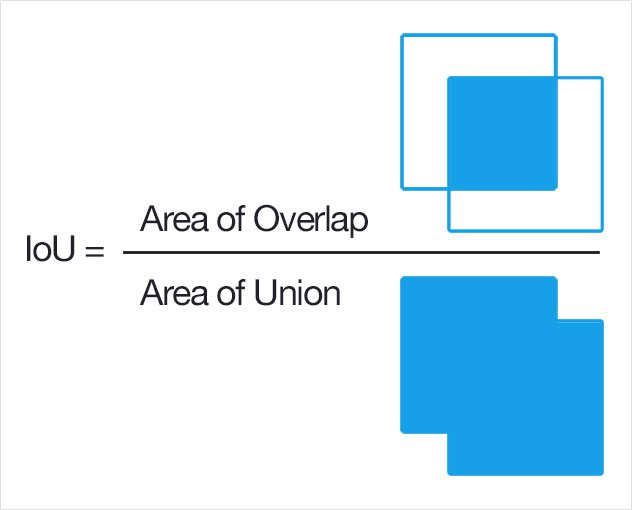

IoU(Intersection over Union)는 **두 영역의 교집합(intersection) 넓이를 합집합(union) 넓이로 나눈 값**

$$
\text{IoU} = \frac{\text{Intersection 영역}}{\text{Union 영역}}
$$

이 지표는 객체의 절대적인 크기와 상관없이, 모델이 얼마나 정확하게 해당 영역을 찾았는지를 **상대적인 비율**로 평가할 수 있게 해준다.
따라서 **모델의 영역 탐지 성능 비교에 매우 유용한 지표**ㅇ;다.


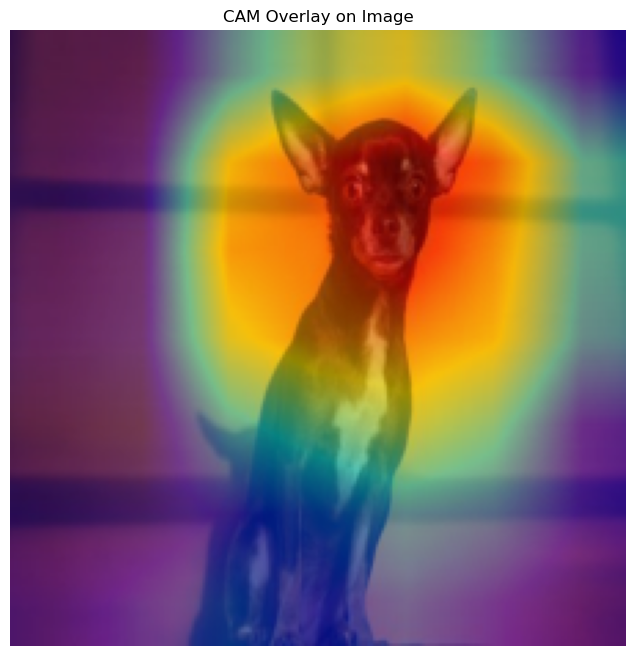

In [30]:
image, label, ground_bbox = train_dataset[10]
sample_image = image.unsqueeze(0).to(device)
orig_img = unnormalize(image)
grad_cam = generate_grad_cam(model, sample_image, target_layer_name="layer4")

visualize_cam_on_image(grad_cam, orig_img)

In [31]:
def get_bbox(cam, threshold=0.01):
    coords = np.argwhere(cam > threshold)
    if coords.size == 0:
        return None
    # np.argwhere의 결과는 (row, col) 즉, (y, x) 순서입니다.
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)
    return (x_min, y_min, x_max, y_max)

In [32]:
cam_resized = cv2.resize(cam, (orig_img.shape[1], orig_img.shape[0]))
bbox = get_bbox(cam_resized, threshold=0.5)

print(bbox)

(np.int64(54), np.int64(35), np.int64(184), np.int64(196))


In [33]:
def visualize_bbox_on_image(img, bbox, box_color=(255, 0, 0), thickness=2):
    # 원본 이미지 복사
    img_with_bbox = img.copy()
    if bbox is not None:
        x_min, y_min, x_max, y_max = bbox
        cv2.rectangle(img_with_bbox, (x_min, y_min), (x_max, y_max), box_color, thickness)
    else:
        print("활성화된 영역이 없습니다.")
    return img_with_bbox

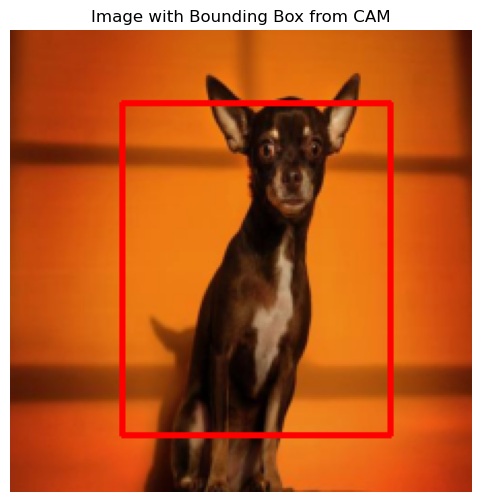

In [34]:
img_bbox = visualize_bbox_on_image(orig_img, bbox)

plt.figure(figsize=(6,6))
plt.imshow(img_bbox)
plt.title("Image with Bounding Box from CAM")
plt.axis("off")
plt.show()

In [35]:
ground_bbox

[78.848, 19.333333333333332, 169.792, 222.0]

In [36]:
def get_iou(bbox1, bbox2):
    # bbox 중 하나라도 None이면 IoU 0.0
    if bbox1 is None or bbox2 is None:
        return 0.0

    x_min1, y_min1, x_max1, y_max1 = bbox1
    x_min2, y_min2, x_max2, y_max2 = bbox2

    # 두 bbox의 교집합 영역 좌표 계산
    x_min_inter = max(x_min1, x_min2)
    y_min_inter = max(y_min1, y_min2)
    x_max_inter = min(x_max1, x_max2)
    y_max_inter = min(y_max1, y_max2)

    # 교집합의 너비와 높이 (음수가 되지 않도록)
    inter_width = max(0, x_max_inter - x_min_inter)
    inter_height = max(0, y_max_inter - y_min_inter)
    inter_area = inter_width * inter_height

    # 각 bbox의 면적 계산
    area1 = (x_max1 - x_min1) * (y_max1 - y_min1)
    area2 = (x_max2 - x_min2) * (y_max2 - y_min2)

    # 합집합 면적: A ∪ B = A + B - A ∩ B
    union_area = area1 + area2 - inter_area
    if union_area <= 0:
        return 0.0

    iou = inter_area / union_area
    return iou

In [37]:
get_iou(bbox, ground_bbox)

np.float64(0.5923292429677176)

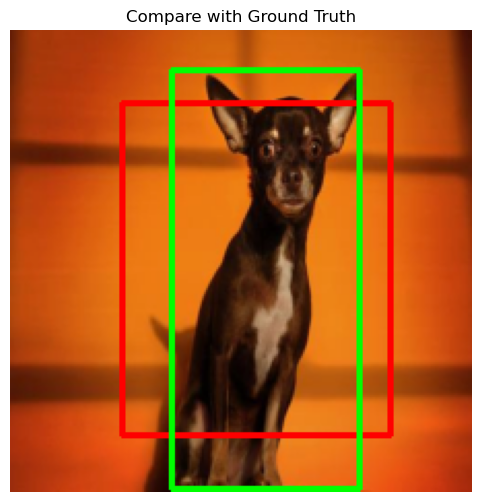

In [38]:
def visualize_both_bbox_on_image(img, bbox, ground_truth, thickness=2):
    # 원본 이미지 복사
    img_with_bbox = img.copy()

    x_min, y_min, x_max, y_max = bbox
    cv2.rectangle(img_with_bbox, (x_min, y_min), (x_max, y_max), (255, 0, 0), thickness)

    x_min_t, y_min_t, x_max_t, y_max_t = ground_truth
    cv2.rectangle(img_with_bbox, (x_min_t, y_min_t), (x_max_t, y_max_t), (0, 255, 0), thickness)

    return img_with_bbox

ground_truth = [int(x) for x in ground_bbox]

img_bbox = visualize_both_bbox_on_image(orig_img, bbox, ground_truth)

plt.figure(figsize=(6,6))
plt.imshow(img_bbox)
plt.title("Compare with Ground Truth")
plt.axis("off")
plt.show()